In [1]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import array

Welcome to JupyROOT 6.24/06


### Read csv file with parameters and put it into an array of dictionary

In [2]:
tree = ROOT.TTree("tree","tree");
tree.ReadFile("f_table_wilkinson74.csv");
Z = np.zeros(1,dtype=int)
A = np.zeros(1,dtype=int)
An = np.zeros(20)
tree.SetBranchAddress("Z",Z);
tree.SetBranchAddress("A",A);
tree.SetBranchAddress("An",An);
ftable = []
for i in range(tree.GetEntries()):
    tree.GetEntry(i)
    An_c=[]
    Z_c=Z[0]
    A_c=A[0]
    for j in An:
        An_c.append(j)
    ftable.append({"Z": Z_c,"A": A_c,"An": An_c})
np.save("f_table_wilkinson74.npy",ftable)

### Load .npy file and create a function

In [3]:
ftable  = np.load("f_table_wilkinson74.npy",allow_pickle='TRUE')

In [4]:
def f_func(x,p):
    Z = int(p[0])
    E = p[1]-x[0]
    W = E/0.510998918+1 #unit of mec2
    if (W**2-1)<0:
        p0 = 0
    else:
        p0 = np.sqrt(W**2-1)
    if (W+p0)<0:
        fZ0 = 1./60.*(2*W**4-9*W**2-8)*p0 +1/4*W
    else:
        fZ0 = 1./60.*(2*W**4-9*W**2-8)*p0 +1/4*W*np.log(W+p0)
    An = ftable[Z-2]["An"]
    An_i=[]
    if (E<0.079):
        An_i.append(An[0])
        An_i.append(An[1])
        An_i.append(An[2])
        An_i.append(An[3])
    elif (E>=0.079 and E<0.501):
        An_i.append(An[4])
        An_i.append(An[5])
        An_i.append(An[6])
        An_i.append(An[7])
    elif (E>=0.501 and E<3.162):
        An_i.append(An[8])
        An_i.append(An[9])
        An_i.append(An[10])
        An_i.append(An[11])
    elif (E>=3.162 and E<12.589):
        An_i.append(An[12])
        An_i.append(An[13])
        An_i.append(An[14])
        An_i.append(An[15])
    elif (E>=12.589):
        An_i.append(An[16])
        An_i.append(An[17])
        An_i.append(An[18])
        An_i.append(An[19])
    if (E<0):
        E = 0.001
    S = np.exp(An_i[0]+An_i[1]*np.log(E)+An_i[2]*(np.log(E)**2)+An_i[3]*(np.log(E)**3))
    return fZ0*S          

### Numerator to calculate mean energy

In [5]:
def f_func_num(x,p):
    return f_func(x,p)*(x[0]-p[2])

In [6]:
def evalEmean(Qb,Sn,ZZ):  
    f_d = ROOT.TF1("f_func",f_func,0.,Qb,2);
    f_d.SetParameter(0,ZZ)
    f_d.SetParameter(1,Qb)
    f_n = ROOT.TF1("f_func_num",f_func_num,0.,Qb,3);
    f_n.SetParameter(0,ZZ)
    f_n.SetParameter(1,Qb)
    f_n.SetParameter(2,Sn)
    return f_n.Integral(Sn,Qb,0.01)/f_d.Integral(Sn,Qb,0.01)

In [7]:
def evalEmeanVar(Qb,Sn,dQb,dSn,ZZ,n=1000):
    retVal = []
    r = ROOT.TRandom3()
    for i in range(n):
        Sn_i = r.Gaus(Sn,dSn)
        Qb_i = r.Gaus(Qb,dQb)
        retVal.append(evalEmean(Qb_i,Sn_i,ZZ))
    retVal = array.array('f',retVal)
    meanfit = ROOT.TMath.Mean(n,retVal)
    mean = evalEmean(Qb,Sn,ZZ)
    sigma = ROOT.TMath.RMS(n,retVal)
    return mean,sigma,meanfit

In [8]:
def cal_eff(E):
    gr = ROOT.TGraph("upc_brikenV69_wClover.txt","%*lg %*lg %*lg %lg %lg %*lg")
    return gr.Eval(E)

In [9]:
def cal_all(Qb,Sn,dQb,dSn,e_factor,Z):
    mean,sigma,meanfit = evalEmeanVar(Qb,Sn,dQb,dSn,Z)
    e_mean = mean * e_factor
    e_mean_fit = meanfit * e_factor
    e_sigma = sigma * e_factor
    e_low  = e_mean - np.sqrt((e_mean-e_mean/2)**2+e_sigma**2)
    if (e_low<0):
        e_low  = e_mean/2
    e_hi = e_mean + np.sqrt((e_mean*2-e_mean)**2+e_sigma**2)
    return e_mean,cal_eff(e_mean),e_low,cal_eff(e_low),e_hi,cal_eff(e_hi),e_mean_fit,e_sigma

In [10]:
print(evalEmean(14.464,3.63119,24))

1.631078178700914


In [11]:
e_mean,eff_mean,e_low,eff_low,e_hi,eff_hi,e_mean_fit,e_sigma = cal_all(14.464,3.63119,1.,1.,0.5,49)
print(e_mean,eff_mean,e_low,eff_low,e_hi,eff_hi,e_mean_fit,e_sigma)

0.8351454299413723 0.6608833102226969 0.4033581721476716 0.6695932836557046 1.6774880875676934 0.6331402858983755 0.8385558662414551 0.10987840417941033


In [12]:
def cal_bash(inputfile, outputfile,e_factor=1):    
    file1 = open(inputfile,'r')
    count = 0
    outlines = []
    while True:
        count+=1
        line = file1.readline()
        if not line:
            break
        line = line.strip().split()
        Qb = float(line[2])
        Sn = float(line[1])
        dQb = float(line[4])
        dSn = float(line[3])
        ZZ = int(line[0])
        #print(line)
        e_mean,eff_mean,e_low,eff_low,e_hi,eff_hi,e_mean_fit,e_sigma = cal_all(Qb,Sn,dQb,dSn,e_factor,ZZ)
        txt = '%d %.4f %.4f %.4f %.4f %.4f %.4f' % (ZZ,e_mean,eff_mean,e_low,eff_low, e_hi, eff_hi)
        outlines.append(txt+'\n')
        #print(line,'%i - %.4f %.4f %.4f %.4f %.4f %.4f' % (count,e_mean,eff_mean,e_low,eff_low, e_hi, eff_hi))
#         if (count>3):
#             break
    file2 = open(outputfile,'w')
    file2.writelines(outlines)

In [13]:
cal_bash("input_Qb1n.txt","output_Qb1n.txt")

AttributeError: 'Line2D' object has no property 'fmt'

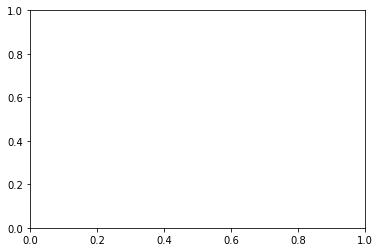

In [18]:
file1 = open("input_Qb1n.txt",'r')
count = 0
Qb1n = []
while True:
    count+=1
    line = file1.readline()
    if not line:
        break
    line = line.strip().split()
    Qb = float(line[2])
    Sn = float(line[1])
    dQb = float(line[4])
    dSn = float(line[3])
    ZZ = int(line[0])
    Qb1n.append(Qb-Sn)
file2 = open("output_Qb1n.txt",'r')
count = 0
Emean = []
while True:
    count+=1
    line = file2.readline()
    if not line:
        break
    line = line.strip().split()
    Emean.append(float(line[1]))
plt.plot(Qb1n,Emean,)

In [17]:
# cal_bash("input_Qb2n.txt","output_Qb2n.txt",0.5)